[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/internship/Internship_P2.ipynb)

# Getting Ready
Prepare the files and the libraries for the experiment.

In [1]:
# Installs
!pip install -U -q PyDrive

In [2]:
# Imports
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import Callback
import keras.backend as K
import keras.utils as utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import re
from io import StringIO

Using TensorFlow backend.


In [3]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [4]:
# Get the .pow files 
pow_files = [(file['title'], file['id'], re.sub(r'_[0-9]+|.pow', '', file['title'])) 
             for file in file_list if file['title'].find('.pow')>0]
num_examples = len(pow_files)
# Get the categories
categories = list(set([file_info[2] for file_info in pow_files]))
# Get the dictionary of the categories
num_cat = len(categories)
categories_dict = {categories[i] : i for i in range(num_cat)}

In [5]:
print(categories_dict)

{'black_rough': 0, 'black_flat': 1, 'grass_flat': 2, 'cubes': 3, 'flat': 4, 'grass_rough': 5}


# Utils
Helper functions.

In [6]:
def to_one_hot(category):
  assert category < num_cat
  one_hot = np.zeros((num_cat))
  one_hot[category] = 1
  return one_hot

In [7]:
def from_one_hot(one_hot):
  for i in range(len(one_hot)):
    if one_hot[i]==1:
      return i

# Model
Recurrent Neural Network model in Keras.

In [8]:
def get_model1():
  model = Sequential()
  model.add(LSTM(32, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [9]:
def get_model2():
  model = Sequential()
  model.add(LSTM(64, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [0]:
def get_model3():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(32))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [0]:
def get_model4():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(64))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [0]:
def get_model5():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(32))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [0]:
def get_model6():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(64))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

# Data
Preprocess the data: combine all the examples together and introduce padding where necessary. Split the longest time series in the several smaller ones.

In [9]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('cubes')==0 or pow_file[0].find('flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [10]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('black_rough')==0 or pow_file[0].find('grass_rough')==0 \
     or pow_file[0].find('black_flat')==0 or pow_file[0].find('grass_flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [11]:
# Split the biggest examples into separate sequences
max_length = 100
long_dfs = [i for i in range(len(list_df)) if list_df[i][0].shape[0] > max_length]
list_df_cut = list(list_df)
max_examples = 3000
examples_categories = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in reversed(long_dfs):
  df = list_df_cut[i][0]
  category = from_one_hot(list_df_cut[i][1])
  for g, split_df in df.groupby(np.arange(len(df)) // max_length):
    if examples_categories[category] < max_examples:
      list_df_cut.append((split_df, list_df[i][1]))
      examples_categories[category] += 1
  del list_df_cut[i]

In [12]:
# Get only the measurements for current
currents_list = [(np.transpose(np.array(df_cut[0][[2]])), df_cut[1]) for df_cut in list_df_cut]
currents_long = [(np.transpose(currents[0]), currents[1]) for currents in currents_list if currents[0].shape[1]>=max_length]
currents_no_labels = [currents[0] for currents in currents_long]

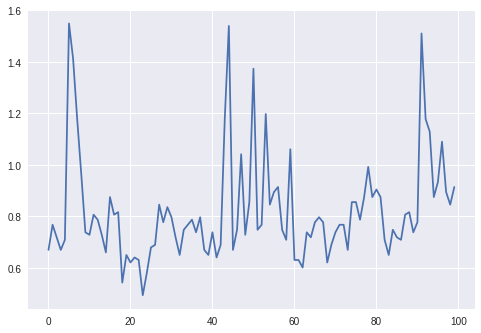

In [13]:
plt.plot(currents_no_labels[0])

In [14]:
# Skip some timesteps
skip = 1
currents_skip = list()
for currents in currents_no_labels:
  currents_skip.append(list())
  i = 0
  while True:
    currents_skip[-1].append(currents[i])
    i += skip
    if i >= len(currents):
      break

In [15]:
# Get training data into a numpy matrix
full_x = np.stack(currents_skip, axis=0)
# Get training labels
full_y = np.array([currents[1] for currents in currents_long])
full_y_labels = [from_one_hot(one_hot) for one_hot in full_y]

In [17]:
print(full_y_labels)
k0 = full_y_labels.index(0)
k1 = full_y_labels.index(1)
k3 = full_y_labels.index(2)
k4 = full_y_labels.index(5)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
full_y_binary = [0 if label==categories_dict['black_flat'] or label==categories_dict['black_rough'] else 1 for label in full_y_labels]
full_x_norm = utils.normalize(full_x, axis=0, order=2)

[0. 1. 0. 0. 0. 0.]


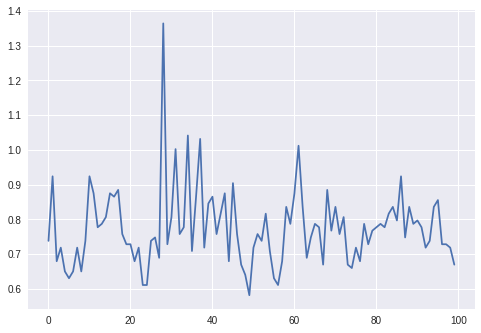

In [21]:
# Training set
#train_x = full_x_norm[10:89]
#train_x = full_x[50:-50]
train_x = np.concatenate((full_x[k0+30:k1], full_x[k1+30:k3], full_x[k3+30:k4], full_x[k4+30:]), axis=0)
train_y = full_y_binary[k0+30:k1] + full_y_binary[k1+30:k3] + full_y_binary[k3+30:k4] + full_y_binary[k4+30:]
# Test set
#test_x = np.concatenate((full_x[:50], full_x[-50:]), axis=0)
test_x = np.concatenate((full_x[k0:k0+30], full_x[k1:k1+30], full_x[k3:k3+30], full_x[k4:k4+30]), axis=0)
#test_y = full_y_binary[:50] + full_y_binary[-50:]
test_y = full_y_binary[k0:k0+30] + full_y_binary[k1:k1+30] + full_y_binary[k3:k3+30] + full_y_binary[k4:k4+30]

plt.plot(full_x[1])
print(full_y[1])

In [22]:
print(full_y_binary)
print(test_y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Experiment

In [62]:
model = get_model2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [63]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.0)

In [64]:
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [0]:
history = model.fit(train_x, train_y, epochs=1500, batch_size=16, shuffle=True)

Epoch 1/1500
565/565 [==============================] - 3s 6ms/step - loss: 0.6912 - acc: 0.5168
Epoch 2/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6911 - acc: 0.5168
Epoch 3/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6911 - acc: 0.5168
Epoch 4/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6910 - acc: 0.5168
Epoch 5/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6910 - acc: 0.5168
Epoch 6/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6910 - acc: 0.5168
Epoch 7/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6910 - acc: 0.5168
Epoch 8/1500


565/565 [==============================] - 2s 4ms/step - loss: 0.6909 - acc: 0.5168
Epoch 9/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6909 - acc: 0.5168
Epoch 10/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6909 - acc: 0.5168
Epoch 11/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6908 - acc: 0.5168
Epoch 12/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6908 - acc: 0.5168
Epoch 13/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6907 - acc: 0.5168
Epoch 14/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6907 - acc: 0.5168
Epoch 15/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6873 - acc: 0.5625

565/565 [==============================] - 2s 4ms/step - loss: 0.6907 - acc: 0.5168
Epoch 16/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6907 - acc: 0.5168
Epoch 17/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6906 - acc: 0.5168
Epoch 18/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6906 - acc: 0.5168
Epoch 19/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6906 - acc: 0.5168
Epoch 20/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6906 - acc: 0.5168
Epoch 21/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6906 - acc: 0.5168
Epoch 22/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6934 - acc: 0.4844

565/565 [==============================] - 2s 4ms/step - loss: 0.6905 - acc: 0.5168
Epoch 23/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6905 - acc: 0.5168
Epoch 24/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6905 - acc: 0.5168
Epoch 25/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6905 - acc: 0.5168
Epoch 26/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6904 - acc: 0.5168
Epoch 27/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6904 - acc: 0.5168
Epoch 28/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6904 - acc: 0.5168
Epoch 29/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.7042 - acc: 0.3906

565/565 [==============================] - 2s 4ms/step - loss: 0.6904 - acc: 0.5168
Epoch 30/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6904 - acc: 0.5168
Epoch 31/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6904 - acc: 0.5168
Epoch 32/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6903 - acc: 0.5168
Epoch 33/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6903 - acc: 0.5168
Epoch 34/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6903 - acc: 0.5168
Epoch 35/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6903 - acc: 0.5168
Epoch 36/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6950 - acc: 0.4688

565/565 [==============================] - 2s 4ms/step - loss: 0.6903 - acc: 0.5168
Epoch 37/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6903 - acc: 0.5168
Epoch 38/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6902 - acc: 0.5168
Epoch 39/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6902 - acc: 0.5168
Epoch 40/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6902 - acc: 0.5168
Epoch 41/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6902 - acc: 0.5168
Epoch 42/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 43/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6847 - acc: 0.5625

565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 44/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 45/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 46/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 47/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 48/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 49/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6900 - acc: 0.5168
Epoch 50/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6891 - acc: 0.5156

565/565 [==============================] - 2s 4ms/step - loss: 0.6901 - acc: 0.5168
Epoch 51/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6900 - acc: 0.5168
Epoch 52/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6900 - acc: 0.5168
Epoch 53/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6900 - acc: 0.5168
Epoch 54/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6900 - acc: 0.5168
Epoch 55/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6900 - acc: 0.5168
Epoch 56/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6899 - acc: 0.5168
Epoch 57/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6879 - acc: 0.5312

565/565 [==============================] - 2s 4ms/step - loss: 0.6899 - acc: 0.5168
Epoch 58/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6899 - acc: 0.5168
Epoch 59/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6899 - acc: 0.5168
Epoch 60/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6899 - acc: 0.5168
Epoch 61/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6899 - acc: 0.5168
Epoch 62/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6898 - acc: 0.5168
Epoch 63/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6898 - acc: 0.5168
Epoch 64/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6795 - acc: 0.6094

565/565 [==============================] - 2s 4ms/step - loss: 0.6898 - acc: 0.5168
Epoch 65/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6898 - acc: 0.5168
Epoch 66/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6898 - acc: 0.5168
Epoch 67/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6898 - acc: 0.5168
Epoch 68/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6897 - acc: 0.5168
Epoch 69/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6897 - acc: 0.5168
Epoch 70/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6897 - acc: 0.5168
Epoch 71/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6879 - acc: 0.5469

565/565 [==============================] - 2s 4ms/step - loss: 0.6897 - acc: 0.5168
Epoch 72/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6897 - acc: 0.5168
Epoch 73/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.5168
Epoch 74/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.5168
Epoch 75/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.5168
Epoch 76/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.5168
Epoch 77/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.5168
Epoch 78/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6788 - acc: 0.5938

565/565 [==============================] - 2s 4ms/step - loss: 0.6896 - acc: 0.5168
Epoch 79/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6895 - acc: 0.5168
Epoch 80/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6895 - acc: 0.5168
Epoch 81/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6895 - acc: 0.5168
Epoch 82/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6895 - acc: 0.5168
Epoch 83/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6895 - acc: 0.5168
Epoch 84/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6894 - acc: 0.5168
Epoch 85/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.7041 - acc: 0.4219

565/565 [==============================] - 2s 4ms/step - loss: 0.6894 - acc: 0.5168
Epoch 86/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6894 - acc: 0.5168
Epoch 87/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6894 - acc: 0.5168
Epoch 88/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6894 - acc: 0.5168
Epoch 89/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6894 - acc: 0.5168
Epoch 90/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6893 - acc: 0.5168
Epoch 91/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6893 - acc: 0.5168
Epoch 92/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6769 - acc: 0.6094

565/565 [==============================] - 2s 4ms/step - loss: 0.6893 - acc: 0.5168
Epoch 93/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6893 - acc: 0.5168
Epoch 94/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6893 - acc: 0.5168
Epoch 95/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6892 - acc: 0.5168
Epoch 96/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6892 - acc: 0.5186
Epoch 97/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6892 - acc: 0.5186
Epoch 98/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6892 - acc: 0.5168
Epoch 99/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.7021 - acc: 0.4062

565/565 [==============================] - 2s 4ms/step - loss: 0.6892 - acc: 0.5186
Epoch 100/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6892 - acc: 0.5186
Epoch 101/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6891 - acc: 0.5186
Epoch 102/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6891 - acc: 0.5186
Epoch 103/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6891 - acc: 0.5186
Epoch 104/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6891 - acc: 0.5186
Epoch 105/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6890 - acc: 0.5186
Epoch 106/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6819 - acc: 0.6042

565/565 [==============================] - 2s 4ms/step - loss: 0.6890 - acc: 0.5186
Epoch 107/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6890 - acc: 0.5186
Epoch 108/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6890 - acc: 0.5186
Epoch 109/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6890 - acc: 0.5186
Epoch 110/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6890 - acc: 0.5186
Epoch 111/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6889 - acc: 0.5186
Epoch 112/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6889 - acc: 0.5186
Epoch 113/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6919 - acc: 0.4792

565/565 [==============================] - 2s 4ms/step - loss: 0.6889 - acc: 0.5186
Epoch 114/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6889 - acc: 0.5186
Epoch 115/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6889 - acc: 0.5186
Epoch 116/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6888 - acc: 0.5186
Epoch 117/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6888 - acc: 0.5186
Epoch 118/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6888 - acc: 0.5186
Epoch 119/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6888 - acc: 0.5186
Epoch 120/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6957 - acc: 0.4583

565/565 [==============================] - 2s 4ms/step - loss: 0.6887 - acc: 0.5186
Epoch 121/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6887 - acc: 0.5186
Epoch 122/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6887 - acc: 0.5186
Epoch 123/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6887 - acc: 0.5186
Epoch 124/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6886 - acc: 0.5186
Epoch 125/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6886 - acc: 0.5186
Epoch 126/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6886 - acc: 0.5186
Epoch 127/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6791 - acc: 0.6042

565/565 [==============================] - 2s 4ms/step - loss: 0.6886 - acc: 0.5186
Epoch 128/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6885 - acc: 0.5186
Epoch 129/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6885 - acc: 0.5186
Epoch 130/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6885 - acc: 0.5186
Epoch 131/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6885 - acc: 0.5186
Epoch 132/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6885 - acc: 0.5186
Epoch 133/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6884 - acc: 0.5186
Epoch 134/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6866 - acc: 0.5208

565/565 [==============================] - 2s 4ms/step - loss: 0.6884 - acc: 0.5186
Epoch 135/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6884 - acc: 0.5186
Epoch 136/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6884 - acc: 0.5186
Epoch 137/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6883 - acc: 0.5204
Epoch 138/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6883 - acc: 0.5186
Epoch 139/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6883 - acc: 0.5186
Epoch 140/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6883 - acc: 0.5221
Epoch 141/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6849 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6882 - acc: 0.5239
Epoch 142/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6882 - acc: 0.5221
Epoch 143/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6882 - acc: 0.5221
Epoch 144/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6882 - acc: 0.5204
Epoch 145/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6881 - acc: 0.5239
Epoch 146/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6881 - acc: 0.5239
Epoch 147/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6881 - acc: 0.5239
Epoch 148/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6665 - acc: 0.6458

565/565 [==============================] - 2s 4ms/step - loss: 0.6880 - acc: 0.5239
Epoch 149/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6880 - acc: 0.5239
Epoch 150/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6880 - acc: 0.5239
Epoch 151/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6880 - acc: 0.5239
Epoch 152/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6879 - acc: 0.5239
Epoch 153/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6879 - acc: 0.5239
Epoch 154/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6879 - acc: 0.5239
Epoch 155/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6943 - acc: 0.5000

565/565 [==============================] - 2s 4ms/step - loss: 0.6879 - acc: 0.5221
Epoch 156/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6878 - acc: 0.5221
Epoch 157/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6878 - acc: 0.5204
Epoch 158/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6878 - acc: 0.5204
Epoch 159/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6877 - acc: 0.5204
Epoch 160/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6877 - acc: 0.5204
Epoch 161/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6877 - acc: 0.5204
Epoch 162/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.7004 - acc: 0.4375

565/565 [==============================] - 2s 4ms/step - loss: 0.6877 - acc: 0.5204
Epoch 163/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6876 - acc: 0.5204
Epoch 164/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6876 - acc: 0.5204
Epoch 165/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6876 - acc: 0.5204
Epoch 166/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6875 - acc: 0.5204
Epoch 167/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6875 - acc: 0.5204
Epoch 168/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6875 - acc: 0.5204
Epoch 169/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6933 - acc: 0.4375

565/565 [==============================] - 2s 4ms/step - loss: 0.6874 - acc: 0.5204
Epoch 170/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6874 - acc: 0.5204
Epoch 171/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6874 - acc: 0.5204
Epoch 172/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6874 - acc: 0.5204
Epoch 173/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6873 - acc: 0.5204
Epoch 174/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6873 - acc: 0.5204
Epoch 175/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6872 - acc: 0.5204
Epoch 176/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.7046 - acc: 0.4583

565/565 [==============================] - 2s 4ms/step - loss: 0.6872 - acc: 0.5204
Epoch 177/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6872 - acc: 0.5204
Epoch 178/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6871 - acc: 0.5204
Epoch 179/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6871 - acc: 0.5204
Epoch 180/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6870 - acc: 0.5204
Epoch 181/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6870 - acc: 0.5204
Epoch 182/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6870 - acc: 0.5204
Epoch 183/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.7051 - acc: 0.4375

565/565 [==============================] - 2s 4ms/step - loss: 0.6869 - acc: 0.5204
Epoch 184/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6869 - acc: 0.5204
Epoch 185/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6869 - acc: 0.5204
Epoch 186/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6868 - acc: 0.5204
Epoch 187/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6868 - acc: 0.5204
Epoch 188/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6868 - acc: 0.5204
Epoch 189/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6867 - acc: 0.5204
Epoch 190/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6761 - acc: 0.6042

565/565 [==============================] - 2s 4ms/step - loss: 0.6867 - acc: 0.5204
Epoch 191/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6866 - acc: 0.5204
Epoch 192/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6866 - acc: 0.5204
Epoch 193/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6865 - acc: 0.5204
Epoch 194/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6865 - acc: 0.5204
Epoch 195/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6864 - acc: 0.5204
Epoch 196/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6864 - acc: 0.5204
Epoch 197/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6793 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6864 - acc: 0.5204
Epoch 198/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6863 - acc: 0.5204
Epoch 199/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6863 - acc: 0.5204
Epoch 200/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6862 - acc: 0.5204
Epoch 201/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6862 - acc: 0.5204
Epoch 202/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6861 - acc: 0.5204
Epoch 203/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6861 - acc: 0.5204
Epoch 204/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6863 - acc: 0.5208

565/565 [==============================] - 2s 4ms/step - loss: 0.6860 - acc: 0.5204
Epoch 205/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6860 - acc: 0.5204
Epoch 206/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6859 - acc: 0.5204
Epoch 207/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6859 - acc: 0.5204
Epoch 208/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6859 - acc: 0.5204
Epoch 209/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6858 - acc: 0.5204
Epoch 210/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6858 - acc: 0.5204
Epoch 211/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6790 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6857 - acc: 0.5204
Epoch 212/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6856 - acc: 0.5204
Epoch 213/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6856 - acc: 0.5204
Epoch 214/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6855 - acc: 0.5204
Epoch 215/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6855 - acc: 0.5204
Epoch 216/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6854 - acc: 0.5204
Epoch 217/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6853 - acc: 0.5204
Epoch 218/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6760 - acc: 0.6458

565/565 [==============================] - 2s 4ms/step - loss: 0.6853 - acc: 0.5204
Epoch 219/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6852 - acc: 0.5204
Epoch 220/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6852 - acc: 0.5221
Epoch 221/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6851 - acc: 0.5204
Epoch 222/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6851 - acc: 0.5204
Epoch 223/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6850 - acc: 0.5221
Epoch 224/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6849 - acc: 0.5221
Epoch 225/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6863 - acc: 0.5625

565/565 [==============================] - 2s 4ms/step - loss: 0.6848 - acc: 0.5221
Epoch 226/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6848 - acc: 0.5221
Epoch 227/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6847 - acc: 0.5221
Epoch 228/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6846 - acc: 0.5221
Epoch 229/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6845 - acc: 0.5221
Epoch 230/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6844 - acc: 0.5221
Epoch 231/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6844 - acc: 0.5221
Epoch 232/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6986 - acc: 0.4792

565/565 [==============================] - 2s 4ms/step - loss: 0.6843 - acc: 0.5221
Epoch 233/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6842 - acc: 0.5221
Epoch 234/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6842 - acc: 0.5221
Epoch 235/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6841 - acc: 0.5221
Epoch 236/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6840 - acc: 0.5239
Epoch 237/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6839 - acc: 0.5239
Epoch 238/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6838 - acc: 0.5239
Epoch 239/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6929 - acc: 0.4583

565/565 [==============================] - 2s 4ms/step - loss: 0.6837 - acc: 0.5239
Epoch 240/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6836 - acc: 0.5239
Epoch 241/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6835 - acc: 0.5239
Epoch 242/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6834 - acc: 0.5239
Epoch 243/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6833 - acc: 0.5257
Epoch 244/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6832 - acc: 0.5239
Epoch 245/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6831 - acc: 0.5274
Epoch 246/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6745 - acc: 0.6250

565/565 [==============================] - 2s 4ms/step - loss: 0.6830 - acc: 0.5257
Epoch 247/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6829 - acc: 0.5257
Epoch 248/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6827 - acc: 0.5274
Epoch 249/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6827 - acc: 0.5274
Epoch 250/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6825 - acc: 0.5292
Epoch 251/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6824 - acc: 0.5274
Epoch 252/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6823 - acc: 0.5274
Epoch 253/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6722 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6822 - acc: 0.5292
Epoch 254/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6821 - acc: 0.5327
Epoch 255/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6819 - acc: 0.5327
Epoch 256/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6817 - acc: 0.5327
Epoch 257/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6816 - acc: 0.5327
Epoch 258/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6815 - acc: 0.5327
Epoch 259/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6814 - acc: 0.5327
Epoch 260/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6969 - acc: 0.4375

565/565 [==============================] - 2s 4ms/step - loss: 0.6812 - acc: 0.5327
Epoch 261/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6811 - acc: 0.5345
Epoch 262/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6810 - acc: 0.5345
Epoch 263/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6808 - acc: 0.5345
Epoch 264/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6807 - acc: 0.5327
Epoch 265/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6805 - acc: 0.5327
Epoch 266/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6804 - acc: 0.5327
Epoch 267/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6684 - acc: 0.6250

565/565 [==============================] - 2s 4ms/step - loss: 0.6802 - acc: 0.5327
Epoch 268/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6800 - acc: 0.5327
Epoch 269/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6798 - acc: 0.5327
Epoch 270/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6796 - acc: 0.5363
Epoch 271/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6795 - acc: 0.5381
Epoch 272/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6793 - acc: 0.5363
Epoch 273/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6791 - acc: 0.5363
Epoch 274/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6868 - acc: 0.5208

565/565 [==============================] - 2s 4ms/step - loss: 0.6789 - acc: 0.5345
Epoch 275/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6787 - acc: 0.5363
Epoch 276/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6785 - acc: 0.5345
Epoch 277/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6783 - acc: 0.5345
Epoch 278/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6781 - acc: 0.5345
Epoch 279/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6779 - acc: 0.5327
Epoch 280/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6776 - acc: 0.5292
Epoch 281/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6773 - acc: 0.4583

565/565 [==============================] - 2s 4ms/step - loss: 0.6774 - acc: 0.5363
Epoch 282/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6771 - acc: 0.5310
Epoch 283/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6769 - acc: 0.5292
Epoch 284/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6767 - acc: 0.5292
Epoch 285/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6764 - acc: 0.5292
Epoch 286/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6762 - acc: 0.5327
Epoch 287/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6759 - acc: 0.5310
Epoch 288/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6602 - acc: 0.5417

565/565 [==============================] - 2s 4ms/step - loss: 0.6756 - acc: 0.5274
Epoch 289/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6753 - acc: 0.5292
Epoch 290/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6750 - acc: 0.5239
Epoch 291/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6748 - acc: 0.5363
Epoch 292/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6744 - acc: 0.5274
Epoch 293/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6741 - acc: 0.5274
Epoch 294/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6738 - acc: 0.5327
Epoch 295/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6995 - acc: 0.5000

565/565 [==============================] - 2s 4ms/step - loss: 0.6735 - acc: 0.5381
Epoch 296/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6732 - acc: 0.5345
Epoch 297/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6729 - acc: 0.5434
Epoch 298/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6725 - acc: 0.5381
Epoch 299/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6722 - acc: 0.5381
Epoch 300/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6718 - acc: 0.5504
Epoch 301/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6716 - acc: 0.5504
Epoch 302/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6494 - acc: 0.6458

565/565 [==============================] - 2s 4ms/step - loss: 0.6712 - acc: 0.5611
Epoch 303/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6710 - acc: 0.5593
Epoch 304/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6706 - acc: 0.5522
Epoch 305/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6703 - acc: 0.5823
Epoch 306/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6701 - acc: 0.5805
Epoch 307/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6696 - acc: 0.5628
Epoch 308/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6691 - acc: 0.6053
Epoch 309/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6654 - acc: 0.5000

565/565 [==============================] - 2s 4ms/step - loss: 0.6690 - acc: 0.5735
Epoch 310/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6686 - acc: 0.5823
Epoch 311/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6683 - acc: 0.5593
Epoch 312/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6680 - acc: 0.5699
Epoch 313/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6676 - acc: 0.6106
Epoch 314/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6674 - acc: 0.5965
Epoch 315/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6668 - acc: 0.6212
Epoch 316/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6516 - acc: 0.6250

565/565 [==============================] - 2s 4ms/step - loss: 0.6666 - acc: 0.6088
Epoch 317/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6661 - acc: 0.6319
Epoch 318/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6660 - acc: 0.6159
Epoch 319/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6653 - acc: 0.6230
Epoch 320/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6650 - acc: 0.6354
Epoch 321/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6644 - acc: 0.6283
Epoch 322/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6642 - acc: 0.6478
Epoch 323/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6431 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6639 - acc: 0.6301
Epoch 324/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6633 - acc: 0.6442
Epoch 325/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6629 - acc: 0.6336
Epoch 326/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6625 - acc: 0.6336
Epoch 327/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6620 - acc: 0.6496
Epoch 328/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6616 - acc: 0.6407
Epoch 329/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6610 - acc: 0.6354
Epoch 330/1500
112/565 [====>.........................] - ETA: 1s - loss: 0.6688 - acc: 0.6786

565/565 [==============================] - 2s 4ms/step - loss: 0.6606 - acc: 0.6619
Epoch 331/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6603 - acc: 0.6619
Epoch 332/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6600 - acc: 0.6372
Epoch 333/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6595 - acc: 0.6531
Epoch 334/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6590 - acc: 0.6460
Epoch 335/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6584 - acc: 0.6566
Epoch 336/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6577 - acc: 0.6584
Epoch 337/1500
256/565 [============>.................] - ETA: 1s - loss: 0.6603 - acc: 0.6484

565/565 [==============================] - 2s 3ms/step - loss: 0.6573 - acc: 0.6690
Epoch 338/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6570 - acc: 0.6496
Epoch 339/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6562 - acc: 0.6726
Epoch 340/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6558 - acc: 0.6496
Epoch 341/1500
565/565 [==============================] - 2s 3ms/step - loss: 0.6554 - acc: 0.6549
Epoch 342/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6543 - acc: 0.6496
Epoch 343/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6541 - acc: 0.6708
Epoch 344/1500
224/565 [==========>...................] - ETA: 1s - loss: 0.6545 - acc: 0.6562

565/565 [==============================] - 2s 4ms/step - loss: 0.6535 - acc: 0.6619
Epoch 345/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6530 - acc: 0.6584
Epoch 346/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6525 - acc: 0.6637
Epoch 347/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6522 - acc: 0.6566
Epoch 348/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6517 - acc: 0.6513
Epoch 349/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6510 - acc: 0.6637
Epoch 350/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6506 - acc: 0.6637
Epoch 351/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6141 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6503 - acc: 0.6566
Epoch 352/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6494 - acc: 0.6673
Epoch 353/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6488 - acc: 0.6655
Epoch 354/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6483 - acc: 0.6637
Epoch 355/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6477 - acc: 0.6549
Epoch 356/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6473 - acc: 0.6673
Epoch 357/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6473 - acc: 0.6708
Epoch 358/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6574 - acc: 0.7500

565/565 [==============================] - 2s 4ms/step - loss: 0.6465 - acc: 0.6619
Epoch 359/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6462 - acc: 0.6726
Epoch 360/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6450 - acc: 0.6637
Epoch 361/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6455 - acc: 0.6690
Epoch 362/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6458 - acc: 0.6726
Epoch 363/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6447 - acc: 0.6513
Epoch 364/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6436 - acc: 0.6708
Epoch 365/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6037 - acc: 0.7500

565/565 [==============================] - 2s 4ms/step - loss: 0.6446 - acc: 0.6673
Epoch 366/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6436 - acc: 0.6743
Epoch 367/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6433 - acc: 0.6602
Epoch 368/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6431 - acc: 0.6549
Epoch 369/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6429 - acc: 0.6655
Epoch 370/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6427 - acc: 0.6673
Epoch 371/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6430 - acc: 0.6637
Epoch 372/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6414 - acc: 0.6458

565/565 [==============================] - 2s 4ms/step - loss: 0.6419 - acc: 0.6637
Epoch 373/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6408 - acc: 0.6602
Epoch 374/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6418 - acc: 0.6673
Epoch 375/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6412 - acc: 0.6531
Epoch 376/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6409 - acc: 0.6726
Epoch 377/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6415 - acc: 0.6549
Epoch 378/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6417 - acc: 0.6584
Epoch 379/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.5991 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6403 - acc: 0.6637
Epoch 380/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6388 - acc: 0.6602
Epoch 381/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6408 - acc: 0.6637
Epoch 382/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6405 - acc: 0.6619
Epoch 383/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6398 - acc: 0.6637
Epoch 384/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6406 - acc: 0.6531
Epoch 385/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6393 - acc: 0.6602
Epoch 386/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.5960 - acc: 0.7292

565/565 [==============================] - 2s 4ms/step - loss: 0.6398 - acc: 0.6655
Epoch 387/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6393 - acc: 0.6637
Epoch 388/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6385 - acc: 0.6655
Epoch 389/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6398 - acc: 0.6566
Epoch 390/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6397 - acc: 0.6619
Epoch 391/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6383 - acc: 0.6673
Epoch 392/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6381 - acc: 0.6655
Epoch 393/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.7241 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6389 - acc: 0.6602
Epoch 394/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6392 - acc: 0.6584
Epoch 395/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6388 - acc: 0.6673
Epoch 396/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6387 - acc: 0.6726
Epoch 397/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6383 - acc: 0.6655
Epoch 398/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6386 - acc: 0.6637
Epoch 399/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6383 - acc: 0.6673
Epoch 400/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6560 - acc: 0.6667

565/565 [==============================] - 2s 4ms/step - loss: 0.6381 - acc: 0.6673
Epoch 401/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6393 - acc: 0.6566
Epoch 402/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6380 - acc: 0.6584
Epoch 403/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6379 - acc: 0.6673
Epoch 404/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6377 - acc: 0.6566
Epoch 405/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6376 - acc: 0.6584
Epoch 406/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6379 - acc: 0.6655
Epoch 407/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6173 - acc: 0.7083

565/565 [==============================] - 2s 4ms/step - loss: 0.6376 - acc: 0.6637
Epoch 408/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6380 - acc: 0.6531
Epoch 409/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6381 - acc: 0.6584
Epoch 410/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6380 - acc: 0.6496
Epoch 411/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6368 - acc: 0.6602
Epoch 412/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6376 - acc: 0.6531
Epoch 413/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6373 - acc: 0.6549
Epoch 414/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6890 - acc: 0.6667

565/565 [==============================] - 2s 4ms/step - loss: 0.6369 - acc: 0.6637
Epoch 415/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6373 - acc: 0.6637
Epoch 416/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6376 - acc: 0.6566
Epoch 417/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6368 - acc: 0.6602
Epoch 418/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6376 - acc: 0.6584
Epoch 419/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6365 - acc: 0.6637
Epoch 420/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6375 - acc: 0.6566
Epoch 421/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6796 - acc: 0.6042

565/565 [==============================] - 2s 4ms/step - loss: 0.6367 - acc: 0.6619
Epoch 422/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6373 - acc: 0.6637
Epoch 423/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6365 - acc: 0.6690
Epoch 424/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6375 - acc: 0.6690
Epoch 425/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6368 - acc: 0.6549
Epoch 426/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6367 - acc: 0.6690
Epoch 427/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6365 - acc: 0.6690
Epoch 428/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6283 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6363 - acc: 0.6637
Epoch 429/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6364 - acc: 0.6619
Epoch 430/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6368 - acc: 0.6602
Epoch 431/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6366 - acc: 0.6637
Epoch 432/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6364 - acc: 0.6708
Epoch 433/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6371 - acc: 0.6602
Epoch 434/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6361 - acc: 0.6619
Epoch 435/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6006 - acc: 0.7083

565/565 [==============================] - 2s 4ms/step - loss: 0.6353 - acc: 0.6602
Epoch 436/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6362 - acc: 0.6549
Epoch 437/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6364 - acc: 0.6619
Epoch 438/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6365 - acc: 0.6619
Epoch 439/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6355 - acc: 0.6531
Epoch 440/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6364 - acc: 0.6584
Epoch 441/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6363 - acc: 0.6637
Epoch 442/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6163 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6358 - acc: 0.6584
Epoch 443/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6370 - acc: 0.6602
Epoch 444/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6363 - acc: 0.6655
Epoch 445/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6357 - acc: 0.6655
Epoch 446/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6345 - acc: 0.6549
Epoch 447/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6361 - acc: 0.6602
Epoch 448/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6361 - acc: 0.6566
Epoch 449/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6033 - acc: 0.7083

565/565 [==============================] - 2s 4ms/step - loss: 0.6357 - acc: 0.6619
Epoch 450/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6348 - acc: 0.6619
Epoch 451/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6357 - acc: 0.6637
Epoch 452/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6358 - acc: 0.6619
Epoch 453/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6348 - acc: 0.6496
Epoch 454/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6353 - acc: 0.6673
Epoch 455/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6362 - acc: 0.6619
Epoch 456/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6965 - acc: 0.5625

565/565 [==============================] - 2s 4ms/step - loss: 0.6357 - acc: 0.6602
Epoch 457/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6353 - acc: 0.6673
Epoch 458/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6352 - acc: 0.6584
Epoch 459/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6360 - acc: 0.6619
Epoch 460/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6356 - acc: 0.6655
Epoch 461/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6351 - acc: 0.6673
Epoch 462/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6355 - acc: 0.6655
Epoch 463/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6703 - acc: 0.6250

565/565 [==============================] - 2s 4ms/step - loss: 0.6354 - acc: 0.6655
Epoch 464/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6356 - acc: 0.6726
Epoch 465/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6353 - acc: 0.6637
Epoch 466/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6341 - acc: 0.6619
Epoch 467/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6354 - acc: 0.6619
Epoch 468/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6360 - acc: 0.6655
Epoch 469/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6353 - acc: 0.6566
Epoch 470/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.7260 - acc: 0.5417

565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6726
Epoch 471/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6584
Epoch 472/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6357 - acc: 0.6673
Epoch 473/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6351 - acc: 0.6619
Epoch 474/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6351 - acc: 0.6619
Epoch 475/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6350 - acc: 0.6602
Epoch 476/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6353 - acc: 0.6637
Epoch 477/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6500 - acc: 0.6667

565/565 [==============================] - 2s 4ms/step - loss: 0.6355 - acc: 0.6602
Epoch 478/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6351 - acc: 0.6619
Epoch 479/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6348 - acc: 0.6584
Epoch 480/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6351 - acc: 0.6619
Epoch 481/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6344 - acc: 0.6655
Epoch 482/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6343 - acc: 0.6655
Epoch 483/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6357 - acc: 0.6637
Epoch 484/1500
 32/565 [>.............................] - ETA: 2s - loss: 0.5880 - acc: 0.7812

565/565 [==============================] - 2s 4ms/step - loss: 0.6344 - acc: 0.6655
Epoch 485/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6347 - acc: 0.6584
Epoch 486/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6346 - acc: 0.6531
Epoch 487/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6340 - acc: 0.6655
Epoch 488/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6655
Epoch 489/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6344 - acc: 0.6619
Epoch 490/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6345 - acc: 0.6602
Epoch 491/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6018 - acc: 0.7083

565/565 [==============================] - 2s 4ms/step - loss: 0.6340 - acc: 0.6637
Epoch 492/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6655
Epoch 493/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6345 - acc: 0.6513
Epoch 494/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6348 - acc: 0.6619
Epoch 495/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6342 - acc: 0.6637
Epoch 496/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6332 - acc: 0.6655
Epoch 497/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6353 - acc: 0.6531
Epoch 498/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.7185 - acc: 0.6042

565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6637
Epoch 499/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6351 - acc: 0.6619
Epoch 500/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6342 - acc: 0.6673
Epoch 501/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6673
Epoch 502/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6343 - acc: 0.6549
Epoch 503/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6346 - acc: 0.6655
Epoch 504/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6346 - acc: 0.6690
Epoch 505/1500
 32/565 [>.............................] - ETA: 2s - loss: 0.6612 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6342 - acc: 0.6655
Epoch 506/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6340 - acc: 0.6655
Epoch 507/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6352 - acc: 0.6566
Epoch 508/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6346 - acc: 0.6566
Epoch 509/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6348 - acc: 0.6655
Epoch 510/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6343 - acc: 0.6602
Epoch 511/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6333 - acc: 0.6549
Epoch 512/1500
 64/565 [==>...........................] - ETA: 1s - loss: 0.6313 - acc: 0.6406

565/565 [==============================] - 2s 4ms/step - loss: 0.6337 - acc: 0.6637
Epoch 513/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6345 - acc: 0.6690
Epoch 514/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6337 - acc: 0.6619
Epoch 515/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6348 - acc: 0.6566
Epoch 516/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6341 - acc: 0.6655
Epoch 517/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6346 - acc: 0.6673
Epoch 518/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6344 - acc: 0.6602
Epoch 519/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6746 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6337 - acc: 0.6637
Epoch 520/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6619
Epoch 521/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6343 - acc: 0.6655
Epoch 522/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6343 - acc: 0.6619
Epoch 523/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6673
Epoch 524/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6338 - acc: 0.6673
Epoch 525/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6342 - acc: 0.6549
Epoch 526/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.5726 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6602
Epoch 527/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6340 - acc: 0.6584
Epoch 528/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6602
Epoch 529/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6340 - acc: 0.6655
Epoch 530/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6726
Epoch 531/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6340 - acc: 0.6602
Epoch 532/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6342 - acc: 0.6690
Epoch 533/1500
 32/565 [>.............................] - ETA: 2s - loss: 0.6005 - acc: 0.6562

565/565 [==============================] - 2s 4ms/step - loss: 0.6328 - acc: 0.6619
Epoch 534/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6344 - acc: 0.6619
Epoch 535/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6329 - acc: 0.6619
Epoch 536/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6673
Epoch 537/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6708
Epoch 538/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6338 - acc: 0.6584
Epoch 539/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6619
Epoch 540/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6515 - acc: 0.6042

565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6584
Epoch 541/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6337 - acc: 0.6673
Epoch 542/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6619
Epoch 543/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6344 - acc: 0.6655
Epoch 544/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6341 - acc: 0.6637
Epoch 545/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6341 - acc: 0.6619
Epoch 546/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6619
Epoch 547/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.5957 - acc: 0.7083

565/565 [==============================] - 2s 4ms/step - loss: 0.6330 - acc: 0.6637
Epoch 548/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6566
Epoch 549/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6338 - acc: 0.6496
Epoch 550/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6343 - acc: 0.6673
Epoch 551/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6655
Epoch 552/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6332 - acc: 0.6655
Epoch 553/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6655
Epoch 554/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6205 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6337 - acc: 0.6566
Epoch 555/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6655
Epoch 556/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6331 - acc: 0.6619
Epoch 557/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6341 - acc: 0.6584
Epoch 558/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6566
Epoch 559/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6326 - acc: 0.6531
Epoch 560/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6673
Epoch 561/1500
 32/565 [>.............................] - ETA: 2s - loss: 0.6328 - acc: 0.6250

565/565 [==============================] - 2s 4ms/step - loss: 0.6330 - acc: 0.6673
Epoch 562/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6584
Epoch 563/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6341 - acc: 0.6708
Epoch 564/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6328 - acc: 0.6673
Epoch 565/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6326 - acc: 0.6690
Epoch 566/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6602
Epoch 567/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6655
Epoch 568/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6920 - acc: 0.6042

565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6637
Epoch 569/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6329 - acc: 0.6655
Epoch 570/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6673
Epoch 571/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6338 - acc: 0.6637
Epoch 572/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6602
Epoch 573/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6333 - acc: 0.6584
Epoch 574/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6325 - acc: 0.6513
Epoch 575/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.5878 - acc: 0.7292

565/565 [==============================] - 2s 4ms/step - loss: 0.6339 - acc: 0.6637
Epoch 576/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6726
Epoch 577/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6328 - acc: 0.6690
Epoch 578/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6333 - acc: 0.6602
Epoch 579/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6690
Epoch 580/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6331 - acc: 0.6637
Epoch 581/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6584
Epoch 582/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.5801 - acc: 0.7500

565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6673
Epoch 583/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6329 - acc: 0.6690
Epoch 584/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6344 - acc: 0.6655
Epoch 585/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6332 - acc: 0.6602
Epoch 586/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6335 - acc: 0.6690
Epoch 587/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6673
Epoch 588/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6329 - acc: 0.6655
Epoch 589/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6426 - acc: 0.6458

565/565 [==============================] - 2s 4ms/step - loss: 0.6330 - acc: 0.6673
Epoch 590/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6531
Epoch 591/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6673
Epoch 592/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6602
Epoch 593/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6619
Epoch 594/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6325 - acc: 0.6690
Epoch 595/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6333 - acc: 0.6655
Epoch 596/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.5864 - acc: 0.7083

565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6673
Epoch 597/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6328 - acc: 0.6619
Epoch 598/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6336 - acc: 0.6619
Epoch 599/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6690
Epoch 600/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6326 - acc: 0.6637
Epoch 601/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6331 - acc: 0.6584
Epoch 602/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6326 - acc: 0.6655
Epoch 603/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6203 - acc: 0.6667

565/565 [==============================] - 2s 4ms/step - loss: 0.6326 - acc: 0.6619
Epoch 604/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6330 - acc: 0.6637
Epoch 605/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6602
Epoch 606/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6330 - acc: 0.6690
Epoch 607/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6566
Epoch 608/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6330 - acc: 0.6655
Epoch 609/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6330 - acc: 0.6637
Epoch 610/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.5870 - acc: 0.7292

565/565 [==============================] - 2s 4ms/step - loss: 0.6331 - acc: 0.6496
Epoch 611/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6584
Epoch 612/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6319 - acc: 0.6673
Epoch 613/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6329 - acc: 0.6655
Epoch 614/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6655
Epoch 615/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6584
Epoch 616/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6637
Epoch 617/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.7514 - acc: 0.5417

565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6655
Epoch 618/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6325 - acc: 0.6655
Epoch 619/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6602
Epoch 620/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6673
Epoch 621/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6655
Epoch 622/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6743
Epoch 623/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6328 - acc: 0.6566
Epoch 624/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6418 - acc: 0.6875

565/565 [==============================] - 2s 4ms/step - loss: 0.6326 - acc: 0.6566
Epoch 625/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6743
Epoch 626/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6329 - acc: 0.6690
Epoch 627/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6673
Epoch 628/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6602
Epoch 629/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6319 - acc: 0.6655
Epoch 630/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6331 - acc: 0.6655
Epoch 631/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.5834 - acc: 0.7083

565/565 [==============================] - 2s 4ms/step - loss: 0.6316 - acc: 0.6708
Epoch 632/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6334 - acc: 0.6708
Epoch 633/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6673
Epoch 634/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6602
Epoch 635/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6690
Epoch 636/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6655
Epoch 637/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6328 - acc: 0.6673
Epoch 638/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6971 - acc: 0.5833

565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6619
Epoch 639/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6637
Epoch 640/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6326 - acc: 0.6637
Epoch 641/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6311 - acc: 0.6708
Epoch 642/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6332 - acc: 0.6584
Epoch 643/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6327 - acc: 0.6619
Epoch 644/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6690
Epoch 645/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6478 - acc: 0.6458

565/565 [==============================] - 2s 4ms/step - loss: 0.6315 - acc: 0.6690
Epoch 646/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6316 - acc: 0.6619
Epoch 647/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6325 - acc: 0.6655
Epoch 648/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6320 - acc: 0.6637
Epoch 649/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6317 - acc: 0.6655
Epoch 650/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6323 - acc: 0.6690
Epoch 651/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6318 - acc: 0.6637
Epoch 652/1500
 48/565 [=>............................] - ETA: 2s - loss: 0.6422 - acc: 0.6250

565/565 [==============================] - 2s 4ms/step - loss: 0.6324 - acc: 0.6708
Epoch 653/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6320 - acc: 0.6637
Epoch 654/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6329 - acc: 0.6637
Epoch 655/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6321 - acc: 0.6673
Epoch 656/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6318 - acc: 0.6708
Epoch 657/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6309 - acc: 0.6655
Epoch 658/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6317 - acc: 0.6602
Epoch 659/1500
 48/565 [=>............................] - ETA: 1s - loss: 0.6650 - acc: 0.6250

565/565 [==============================] - 2s 4ms/step - loss: 0.6316 - acc: 0.6602
Epoch 660/1500
565/565 [==============================] - 2s 4ms/step - loss: 0.6322 - acc: 0.6584
Epoch 661/1500
464/565 [=======================>......] - ETA: 0s - loss: 0.6295 - acc: 0.6616

Text(0.5,0,'epoch')

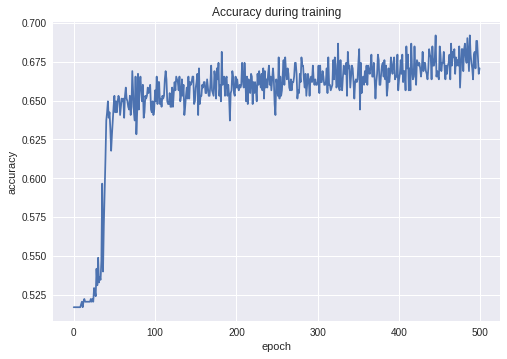

In [59]:
# Plot the accuracy during training
plt.plot(history.history['acc'])
plt.title("Accuracy during training")
plt.ylabel("accuracy")
plt.xlabel("epoch")

Text(0.5,0,'epoch')

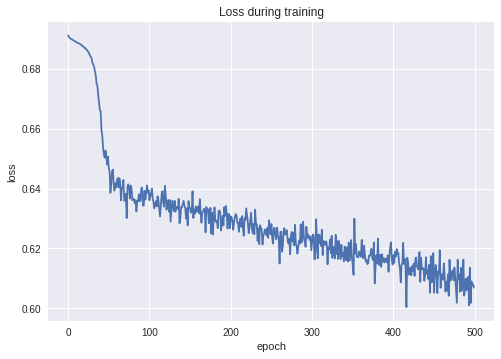

In [60]:
plt.plot(history.history['loss'])
plt.title("Loss during training")
plt.ylabel("loss")
plt.xlabel("epoch")

In [61]:
# Evalute the same model
model.evaluate(x=test_x, y=test_y)


120/120 [==============================] - 0s 577us/step


[0.6427121778329213, 0.6416666626930236]